-------------
## １．ライブラリのインポート aaa

In [ ]:
# 基本的なライブラリ aaa
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.linear_model import Lasso

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
from matplotlib import cm
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
## ２．実験設定

In [2]:
### 実験データの設定 ###
TRAIN_SIZE = 100000
TEST_SIZE = 100000
THRESHOLD = 2  # 外れ値除外のための閾値
TARGET = "GMV"  # "GMV" or "BCR"（目的変数）
features_list = [   # 特徴量のリスト
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]
ALL_FEATURES_INDEX = [i for i in range(len(features_list))]

### 実験設定 ###
N_CLUSTERS = 10 # Kmeansクラスタリングのクラスタ数
K_MIN = 2 # 最小クラスタ数
K_MAX = 10 # 最大クラスタ数


### シード ###
RANDOM_STATE = 0

-----------
## ３．データの前処理

### データ読み込み

In [ ]:
df_all = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
df_train = df_all.iloc[:TRAIN_SIZE]
df_test = df_all.iloc[TRAIN_SIZE : TRAIN_SIZE + TEST_SIZE]

### "GMV" から新しい変数 "BCR" を作成

In [ ]:
df_train = df_train.copy()
df_train["BCR"] = np.where(df_train["GMV"] > 0, 1, 0)
df_test = df_test.copy()
df_test["BCR"] = np.where(df_test["GMV"] > 0, 1, 0)

### 外れ値除去

In [5]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

In [6]:
df_train = remove_outliers_zscore(data=df_train, metric=TARGET, threshold=THRESHOLD)
df_train = df_train.reset_index(drop=True)  # 行を詰める
df_test = remove_outliers_zscore(data=df_test, metric=TARGET, threshold=THRESHOLD)
df_test = df_test.reset_index(drop=True)  # 行を詰める

print("外れ値除外前のデータ数（訓練）:", TRAIN_SIZE)
print("外れ値除外後のデータ数（訓練）:", len(df_train))
print("外れ値除外前のデータ数（テスト）:", TEST_SIZE)
print("外れ値除外後のデータ数（テスト）:", len(df_test))

外れ値除外前のデータ数（訓練+テスト）: 200000
外れ値除外後のデータ数（訓練+テスト）: 198151


### numpy 配列作成

In [7]:
X_train = df_train[features_list].to_numpy()
y_train = df_train[TARGET].to_numpy()

X_test = df_test[features_list].to_numpy()
y_test = df_test[TARGET].to_numpy()

訓練データのデータ数: 99075
テストデータのデータ数: 99076


### 標準化

In [8]:
sc = StandardScaler()
# 訓練データに基づいてfit
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

-------------
### Kmeansのクラスタ数確認

In [9]:
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(X_test_std)
cluster_size = np.bincount(labels)

print(cluster_size)

[ 6760  2114 22086  2516 10472 33197     2   264  5926 15739]


-------------
### Xmeans で確認

##### Xmeans

In [10]:
def compute_bic(X, kmeans):
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_k = k_min
    score_dict = {}
    score_dict[k_min] = best_bic
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        score_dict[k] = current_bic
        if current_bic < best_bic:
            best_bic = current_bic
            best_k = k
    return best_k, score_dict

##### クラスタリング結果

n_clusters chosen in Xmeans: 10


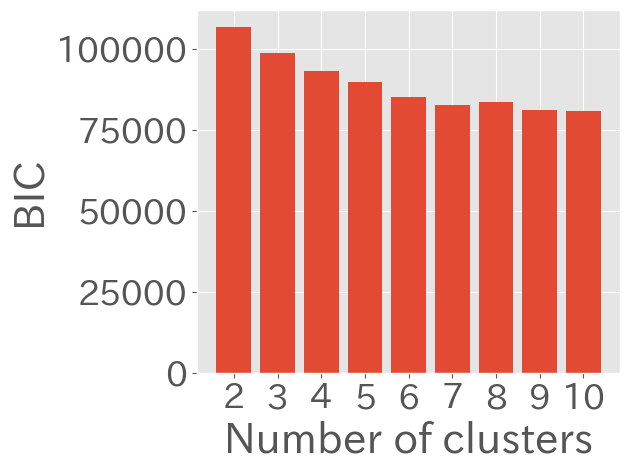

In [11]:
best_k, score_dict = xmeans(X_train_std, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("BIC", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()

-----------------------------
### シルエット係数で確認

In [12]:
def silhouette(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    best_score = silhouette_score(X, labels)
    score_dict = {}
    score_dict[k_min] = best_score
    best_k = k_min
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        labels = kmeans.predict(X)
        current_score = silhouette_score(X, labels)
        score_dict[k] = current_score
        if current_score > best_score:
            best_score = current_score
            best_k = k
    return best_k, score_dict

##### 結果

n_clusters chosen in Xmeans: 2


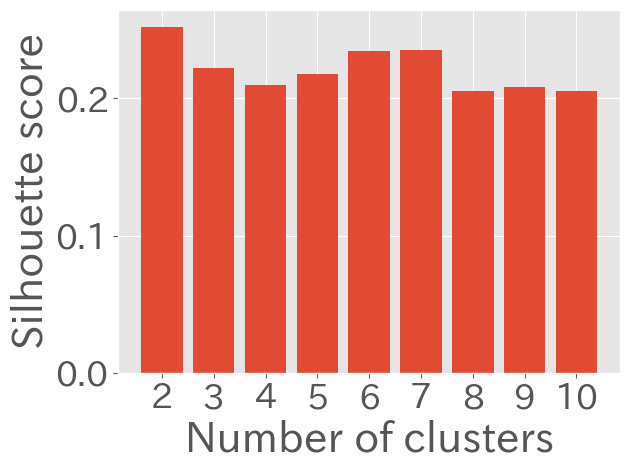

In [13]:
best_k, score_dict = silhouette(X_train_std, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("Silhouette score", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()

In [14]:
print(score_dict)

{2: 0.2518372633205126, 3: 0.22222896633834574, 4: 0.2099537390230404, 5: 0.21785818318550204, 6: 0.23434477689659372, 7: 0.23497858867322605, 8: 0.20553129021885508, 9: 0.2085588352518095, 10: 0.20539683501211906}


### シルエット図

In [9]:
def plot_silhouette_diagram(n_clusters: int, X):
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X)
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]

    silhouette_vals = silhouette_samples(X, labels, metric="euclidean")
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(
            range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor="none",
            color=color,
        )
        yticks.append((y_ax_lower + y_ax_upper) / 2.0)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel("Cluster", fontsize=30)
    plt.xlabel("Silhouette coefficient", fontsize=30)
    plt.tick_params(axis="both", which="major", labelsize=25)
    plt.xlim(-0.6, 0.6)
    plt.tight_layout()
    plt.show()


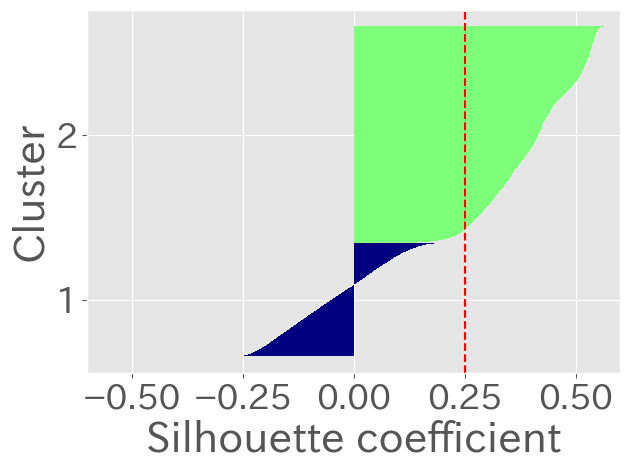

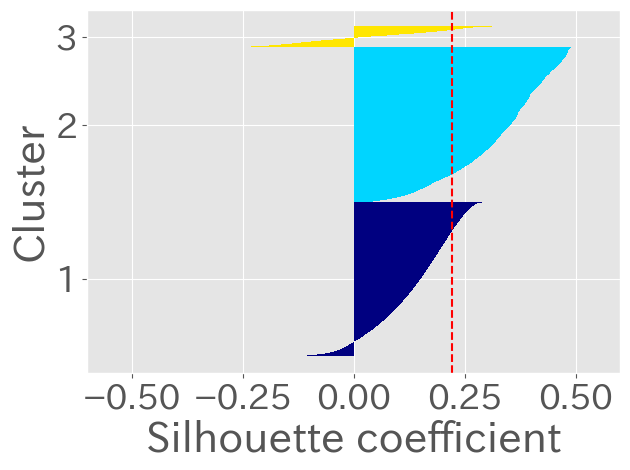

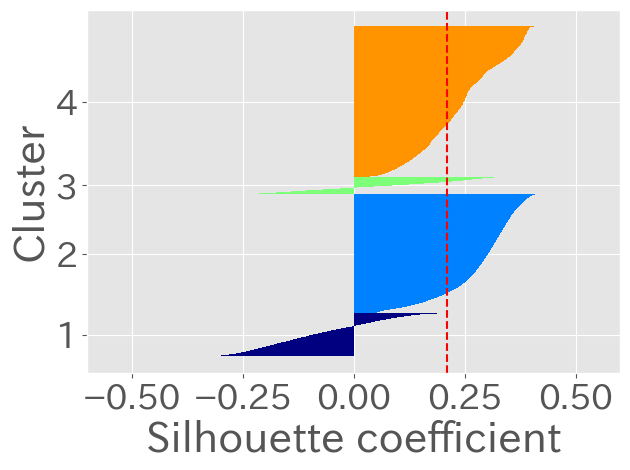

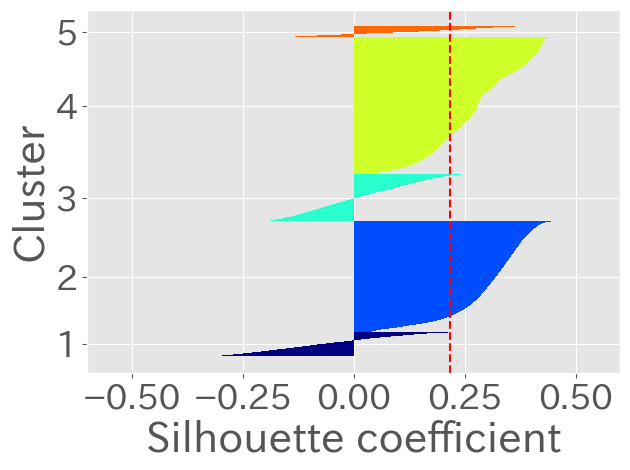

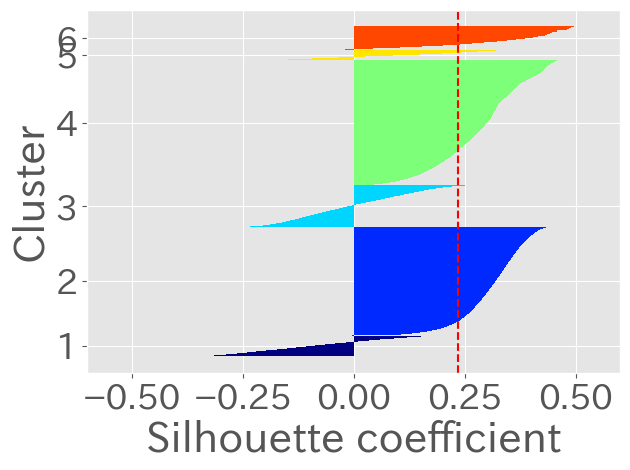

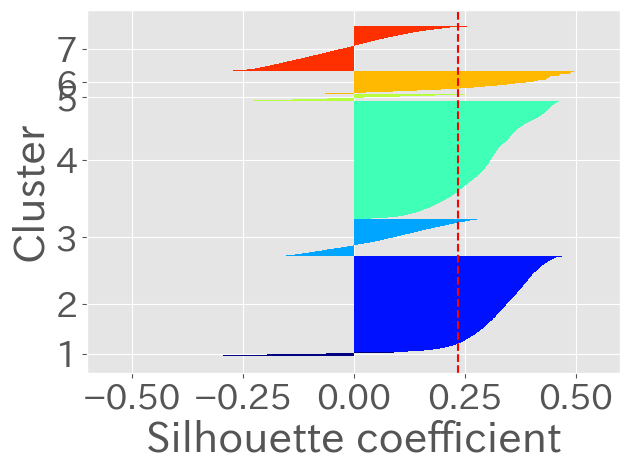

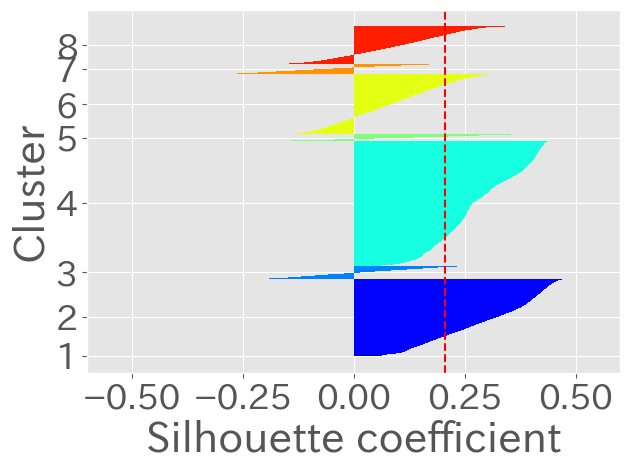

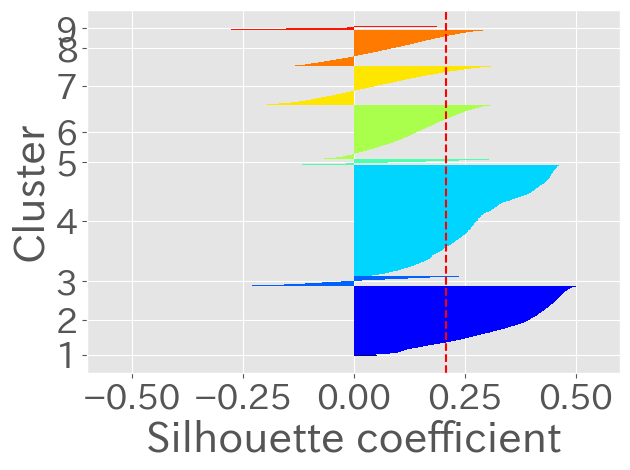

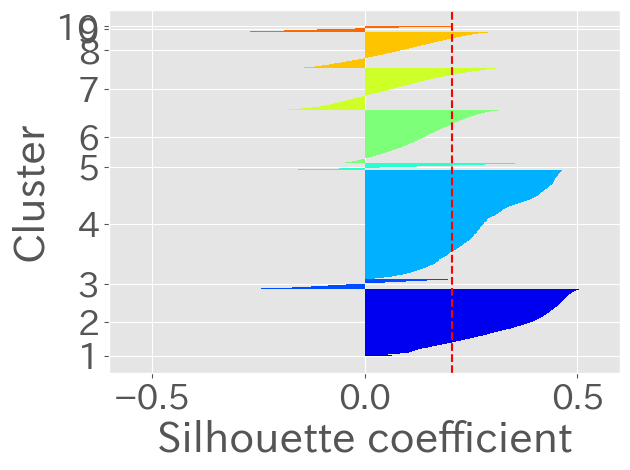

In [10]:
for n_clusters in range(K_MIN, K_MAX + 1):
    plot_silhouette_diagram(n_clusters=n_clusters, X=X_train_std)


-----
## エルボー図

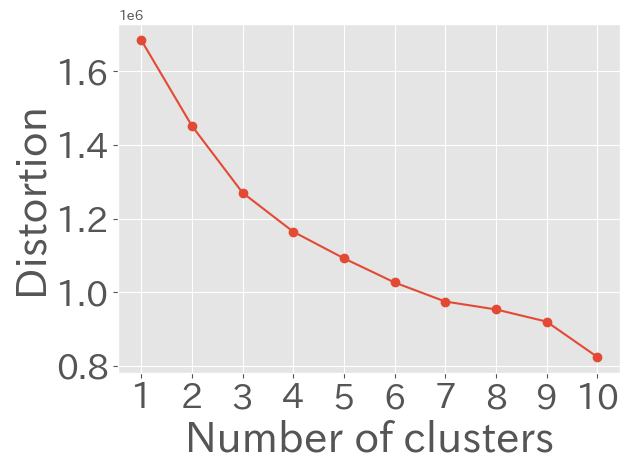

In [34]:
distortions = []
for i in range(K_MIN - 1, K_MAX + 1):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_train_std)
    distortions.append(kmeans.inertia_)

plt.plot(range(K_MIN - 1, K_MAX + 1), distortions, marker="o")
plt.xlabel("Number of clusters", fontsize=30)
plt.ylabel("Distortion", fontsize=30)
plt.xticks(range(K_MIN - 1, K_MAX + 1))
plt.tick_params(axis="both", labelsize=25)
plt.tight_layout()
plt.show()
